In [1]:
!pip -q install catboost lightgbm scikit-learn matplotlib -U

In [2]:
!pip -q install catboost lightgbm scikit-learn matplotlib -U
!pip -q install pandas==2.2.2

In [17]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    precision_recall_curve, roc_curve, f1_score
)
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb

Loaded: 200,000 rows, 11 columns
0:	test: 0.6688352	best: 0.6688352 (0)	total: 253ms	remaining: 4m 12s
100:	test: 0.6880958	best: 0.6882284 (88)	total: 21.1s	remaining: 3m 7s
200:	test: 0.6935990	best: 0.6939990 (190)	total: 38.8s	remaining: 2m 34s
300:	test: 0.7019699	best: 0.7019699 (300)	total: 1m 3s	remaining: 2m 26s
400:	test: 0.7095480	best: 0.7095480 (400)	total: 1m 33s	remaining: 2m 20s
500:	test: 0.7125241	best: 0.7125241 (500)	total: 2m 4s	remaining: 2m 4s
600:	test: 0.7140607	best: 0.7140718 (599)	total: 2m 35s	remaining: 1m 43s
700:	test: 0.7161232	best: 0.7161232 (700)	total: 3m 6s	remaining: 1m 19s
800:	test: 0.7164921	best: 0.7168046 (790)	total: 3m 36s	remaining: 53.8s
900:	test: 0.7189224	best: 0.7189512 (881)	total: 4m 7s	remaining: 27.2s
999:	test: 0.7203508	best: 0.7204406 (991)	total: 4m 38s	remaining: 0us

bestTest = 0.7204405864
bestIteration = 991

Shrink model to first 992 iterations.

🔧 Best threshold: 0.69 with F1 score: 0.422

=== CatBoost Evaluation ===
AUC

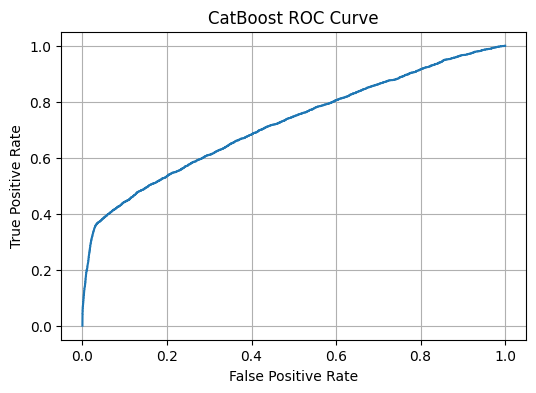

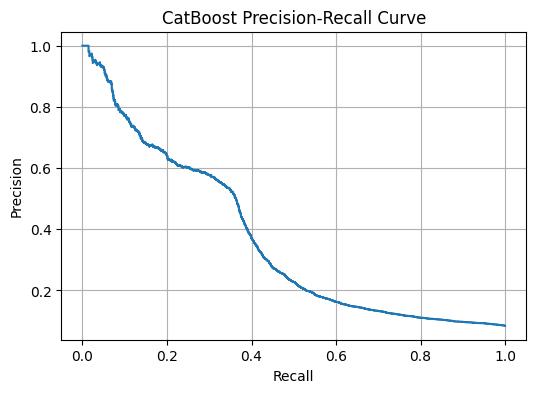


Top CatBoost Feature Importances:
          Feature Id  Importances
0     team_supported    17.808864
1   price_vs_typical    17.791570
2  days_before_event    16.289742
3              price    15.024081
4         event_team     7.994982
5     owner_is_local     7.524059
6        ticket_type     7.330854
7          is_resold     6.077649
8       resale_count     4.158200


In [20]:

# Load dataset
CSV = "SmartTicket_Fuzzy_Realistic_Dataset__200K_.csv"
df = pd.read_csv(CSV)
print(f"Loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")

# Prepare features & target
y = df['is_suspicious']
X = df.drop(columns=['ticket_id', 'is_suspicious'])
cat_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
X_lgb = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Split dataset
X_train_cat, X_val_cat, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train_lgb, X_val_lgb, _, _ = train_test_split(X_lgb, y, test_size=0.2, stratify=y, random_state=42)

# Train CatBoost
train_pool = Pool(X_train_cat, y_train, cat_features=cat_cols)
val_pool = Pool(X_val_cat, y_val, cat_features=cat_cols)

cat_model = CatBoostClassifier(
    iterations=1000,
    depth=10,
    learning_rate=0.05,
    l2_leaf_reg=5,
    class_weights=[1, 15],
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=100
)
cat_model.fit(train_pool, eval_set=val_pool)

cat_pred = cat_model.predict_proba(X_val_cat)[:, 1]

# Optimize threshold for best F1 score
best_f1 = 0
best_thresh = 0.5
for thresh in np.arange(0.1, 0.9, 0.01):
    preds = (cat_pred > thresh).astype(int)
    score = f1_score(y_val, preds)
    if score > best_f1:
        best_f1 = score
        best_thresh = thresh

print(f"\n🔧 Best threshold: {best_thresh:.2f} with F1 score: {best_f1:.3f}")
cat_labels = (cat_pred > best_thresh).astype(int)

# Evaluation
print("\n=== CatBoost Evaluation ===")
print("AUC:", roc_auc_score(y_val, cat_pred).round(4))
print(confusion_matrix(y_val, cat_labels))
print(classification_report(y_val, cat_labels, digits=3))

# Save model and metadata
cat_model.save_model("catboost_model.cbm")
with open("cat_features.json", "w") as f:
    json.dump(cat_cols, f)
with open("catboost_best_threshold.json", "w") as f:
    json.dump({"threshold": float(best_thresh)}, f)

# Train LightGBM
train_set = lgb.Dataset(X_train_lgb, y_train)
val_set = lgb.Dataset(X_val_lgb, y_val, reference=train_set)

lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'learning_rate': 0.05,
    'num_leaves': 64,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42
}
lgb_model = lgb.train(
    lgb_params,
    train_set,
    num_boost_round=800,
    valid_sets=[val_set],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

lgb_pred = lgb_model.predict(X_val_lgb, num_iteration=lgb_model.best_iteration)
lgb_labels = (lgb_pred > best_thresh).astype(int)

print("\n=== LightGBM Evaluation ===")
print("AUC:", roc_auc_score(y_val, lgb_pred).round(4))
print(confusion_matrix(y_val, lgb_labels))
print(classification_report(y_val, lgb_labels, digits=3))

lgb_model.save_model("lightgbm_model.txt")
with open("lgb_feature_cols.json", "w") as f:
    json.dump(X_lgb.columns.tolist(), f)

# Save predictions
val_results = pd.DataFrame({
    "actual": y_val.values,
    "catboost_pred": cat_pred,
    "lightgbm_pred": lgb_pred
})
val_results.to_csv("validation_predictions.csv", index=False)

# Plot ROC and PR curves for CatBoost
fpr, tpr, _ = roc_curve(y_val, cat_pred)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr)
plt.title("CatBoost ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.show()

prec, rec, _ = precision_recall_curve(y_val, cat_pred)
plt.figure(figsize=(6, 4))
plt.plot(rec, prec)
plt.title("CatBoost Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

# Feature importance
print("\nTop CatBoost Feature Importances:")
print(cat_model.get_feature_importance(prettified=True).head(10))